# TODO
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another, create_icon_from_slide_general_path
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v014_hsk6_v1 import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [4]:
truly_load_data = False
to_delete = False

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'hsk6_v1',
 'different_file_name': 'static/hsk/HSK6_sent_cat.csv',
 'custom_filters': [{'col_name': 'index', 'val': 0, 'operator_str': '>='},
  {'col_name': 'index', 'val': 9999, 'operator_str': '<='}],
 'sort_keys': ['category', 'index'],
 'sort_asc': [True, True],
 'voice_name_zh': 'zh-CN-XiaoyuMultilingualNeural',
 'voice_name_en': 'en-US-AvaMultilingualNeural',
 'pause_between_words_ms': 800,
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_combo_quality': 6,
 'categories_allowed': None,
 'categories2_allowed': None,
 'cat1_values_al

# 1. Load data

In [6]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

1003_ec_csent_hsk6_v1 1134


index chinese trad hsk3.0_pinyin                            hsk3.0_def  \
0     66       捕    捕            bǔ  prawn, seizure, seize, arrest, catch   
1    132      宠物   寵物       chǒngwù                                   pet   
2    260      繁殖   繁殖        fánzhí           breed, reproduce, propagate   

                                         video_notes    pinyin  english  \
0  HSK3.0 definition: prawn, seizure, seize, arre...        bǔ  capture   
1                             HSK3.0 definition: pet  chǒng wù      pet   
2     HSK3.0 definition: breed, reproduce, propagate   fán zhí    breed   

     sentence                      sentence_pinyin  \
0    警察成功捕了小偷   jǐng chá chéng gōng bǔ le xiǎo tōu   
1  她养了一只可爱的宠物  tā yǎng le yī zhī kě ài de chǒng wù   
2     动物在春天繁殖        dòng wù zài chūn tiān fán zhí   

                             sentence_english           category  
0  The police successfully captured the thief  Animals & Biology  
1                          She has a cute pet  Animals & Biology  
2                     Animals breed in spring  Animals & Biology

# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 捕
0.011s, ALREADY EXISTS, en-US-AvaMultilingualNeural, capture
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 警察成功捕了小偷
0.0s, row1
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 宠物
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, pet
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 她养了一只可爱的宠物
0.0s, row2
0.001s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 繁殖
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, breed
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 动物在春天繁殖
0.0s, row3
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 公鸡
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, rooster
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 公鸡早晨叫
0.0s, row4
0.002s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 膜
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, membrane
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 眼睛的角膜受伤
0.0s, row5
0.000s, ALREADY EXI

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

Loaded existing audio durations for 1003_ec_csent_hsk6_v1, shape (1134, 15)
Total duration: 6891.51s


chinese    pinyin  english    sentence                      sentence_pinyin  \
0       捕        bǔ  capture    警察成功捕了小偷   jǐng chá chéng gōng bǔ le xiǎo tōu   
1      宠物  chǒng wù      pet  她养了一只可爱的宠物  tā yǎng le yī zhī kě ài de chǒng wù   
2      繁殖   fán zhí    breed     动物在春天繁殖        dòng wù zài chūn tiān fán zhí   

                             sentence_english  d_english  d_chinese  d_sent  \
0  The police successfully captured the thief      1.080      0.768   2.208   
1                          She has a cute pet      0.864      1.032   2.304   
2                     Animals breed in spring      0.936      1.080   1.968   

   rel_start_english  rel_start_chinese  rel_start_sent  sum_theory  combined  \
0                  0              1.580           2.848       5.856  5.855667   
1                  0              1.364           2.896       6.000  5.999667   
2                  0              1.436           3.016       5.784  5.783667   

                                         video_notes nonvocab_file_path  \
0  HSK3.0 definition: prawn, seizure, seize, arre...               None   
1                             HSK3.0 definition: pet               None   
2     HSK3.0 definition: breed, reproduce, propagate               None   

  nonvocab_pause_ms nonvocab_key  
0              None         None  
1              None         None  
2              None         None

# 4. Create non-vocab audio recordings

In [10]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head()

intro audio already generated: 欢迎观看我的普通话数据库视频 14: HSK6级音频卡片
word_list audio already generated: 这些是将在接下来的115分钟内复习的1134个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


chinese  \
0  欢迎观看我的普通话数据库视频 14: HSK6级音频卡片   
1     这些是将在接下来的115分钟内复习的1134个单词   
2                             捕   
3                            宠物   
4                            繁殖   

                                              pinyin  \
0  Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...   
1  Zhèxiē shì jiàng zài jiē xiàlái de 115 fēnzhōn...   
2                                                 bǔ   
3                                           chǒng wù   
4                                            fán zhí   

                                             english    sentence  \
0  Welcome to my Mandarin Chinese Database Video ...         NaN   
1  These are the 1134 words that will be reviewed...         NaN   
2                                            capture    警察成功捕了小偷   
3                                                pet  她养了一只可爱的宠物   
4                                              breed     动物在春天繁殖   

                       sentence_pinyin  \
0                                  NaN   
1                                  NaN   
2   jǐng chá chéng gōng bǔ le xiǎo tōu   
3  tā yǎng le yī zhī kě ài de chǒng wù   
4        dòng wù zài chūn tiān fán zhí   

                             sentence_english  d_english  d_chinese  d_sent  \
0                                         NaN        NaN        NaN     NaN   
1                                         NaN        NaN        NaN     NaN   
2  The police successfully captured the thief      1.080      0.768   2.208   
3                          She has a cute pet      0.864      1.032   2.304   
4                     Animals breed in spring      0.936      1.080   1.968   

   rel_start_english  rel_start_chinese  rel_start_sent  sum_theory  combined  \
0                NaN                NaN             NaN         NaN  7.030000   
1                NaN                NaN             NaN         NaN  7.200000   
2                0.0              1.580           2.848       5.856  5.855667   
3                0.0              1.364           2.896       6.000  5.999667   
4                0.0              1.436           3.016       5.784  5.783667   

                                         video_notes  \
0                                                NaN   
1                                                NaN   
2  HSK3.0 definition: prawn, seizure, seize, arre...   
3                             HSK3.0 definition: pet   
4     HSK3.0 definition: breed, reproduce, propagate   

                                  nonvocab_file_path nonvocab_pause_ms  \
0  output/videos/1003_ec_csent_hsk6_v1/欢迎观看我的普通话数...               500   
1  output/videos/1003_ec_csent_hsk6_v1/这些是将在接下来的1...               500   
2                                               None              None   
3                                               None              None   
4                                               None              None   

  nonvocab_key        end      start  start_english  start_chinese  start_sent  
0        intro   7.030000   0.000000            NaN            NaN         NaN  
1    word_list  14.230000   7.030000            NaN            NaN         NaN  
2         None  20.085667  14.230000      14.230000      15.810000   17.078000  
3         None  26.085333  20.085667      20.085667      21.449667   22.981667  
4         None  31.869000  26.085333      26.085333      27.521333   29.101333

# 5. Combine individual vocab into final audio recording

In [11]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

130.24s, output/videos/1003_ec_csent_hsk6_v1/audio.mp3


# 6. Create images for video

In [12]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

1003_ec_csent_hsk6_v1 loaded


chinese  \
0  欢迎观看我的普通话数据库视频 14: HSK6级音频卡片   
1     这些是将在接下来的115分钟内复习的1134个单词   
2                             捕   
3                            宠物   
4                            繁殖   

                                              pinyin  \
0  Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...   
1  Zhèxiē shì jiàng zài jiē xiàlái de 115 fēnzhōn...   
2                                                 bǔ   
3                                           chǒng wù   
4                                            fán zhí   

                                             english    sentence  \
0  Welcome to my Mandarin Chinese Database Video ...         NaN   
1  These are the 1134 words that will be reviewed...         NaN   
2                                            capture    警察成功捕了小偷   
3                                                pet  她养了一只可爱的宠物   
4                                              breed     动物在春天繁殖   

                       sentence_pinyin  \
0                                  NaN   
1                                  NaN   
2   jǐng chá chéng gōng bǔ le xiǎo tōu   
3  tā yǎng le yī zhī kě ài de chǒng wù   
4        dòng wù zài chūn tiān fán zhí   

                             sentence_english  d_english  d_chinese  d_sent  \
0                                         NaN        NaN        NaN     NaN   
1                                         NaN        NaN        NaN     NaN   
2  The police successfully captured the thief      1.080      0.768   2.208   
3                          She has a cute pet      0.864      1.032   2.304   
4                     Animals breed in spring      0.936      1.080   1.968   

   rel_start_english  rel_start_chinese  rel_start_sent  sum_theory  combined  \
0                NaN                NaN             NaN         NaN  7.030000   
1                NaN                NaN             NaN         NaN  7.200000   
2                0.0              1.580           2.848       5.856  5.855667   
3                0.0              1.364           2.896       6.000  5.999667   
4                0.0              1.436           3.016       5.784  5.783667   

                                         video_notes  \
0                                                NaN   
1                                                NaN   
2  HSK3.0 definition: prawn, seizure, seize, arre...   
3                             HSK3.0 definition: pet   
4     HSK3.0 definition: breed, reproduce, propagate   

                                  nonvocab_file_path  nonvocab_pause_ms  \
0  output/videos/1003_ec_csent_hsk6_v1/欢迎观看我的普通话数...              500.0   
1  output/videos/1003_ec_csent_hsk6_v1/这些是将在接下来的1...              500.0   
2                                                NaN                NaN   
3                                                NaN                NaN   
4                                                NaN                NaN   

  nonvocab_key        end      start  start_english  start_chinese  start_sent  
0        intro   7.030000   0.000000            NaN            NaN         NaN  
1    word_list  14.230000   7.030000            NaN            NaN         NaN  
2          NaN  20.085667  14.230000      14.230000      15.810000   17.078000  
3          NaN  26.085333  20.085667      20.085667      21.449667   22.981667  
4          NaN  31.869000  26.085333      26.085333      27.521333   29.101333

## 6a. Vocab words

Drawing 0: 捕
Drawing 1: 宠物
Drawing 2: 繁殖
Drawing 3: 公鸡
Drawing 4: 膜
Drawing 5: 母鸡
Drawing 6: 奶牛
Drawing 7: 皮球
Drawing 8: 舌头
Drawing 9: 细胞
Drawing 10: 细菌
Drawing 11: 心脏
Drawing 12: 指头
Drawing 13: 变更
Drawing 14: 变形
Drawing 15: 变换
Drawing 16: 重组
Drawing 17: 复苏
Drawing 18: 革新
Drawing 19: 过渡
Drawing 20: 混合
reduced font size to 23
reduced font size to 22
reduced font size to 21
reduced font size to 20
reduced font size to 19
reduced font size to 18
reduced font size to 17
reduced font size to 16
reduced font size to 15
reduced font size to 14
reduced font size to 13
reduced font size to 12
Drawing 21: 开创
Drawing 22: 强化
Drawing 23: 融合
Drawing 24: 融入
Drawing 25: 深化
Drawing 26: 升级
Drawing 27: 实践
Drawing 28: 探索
Drawing 29: 提升
Drawing 30: 消灭
reduced font size to 23
reduced font size to 22
reduced font size to 21
reduced font size to 20
reduced font size to 19
Drawing 31: 新兴
Drawing 32: 再生
Drawing 33: 增进
Drawing 34: 炸
Drawing 35: 整顿
Drawing 36: 整治
Drawing 37: 背心
Drawing 38: 服
Drawing 39: 花瓶
Drawin


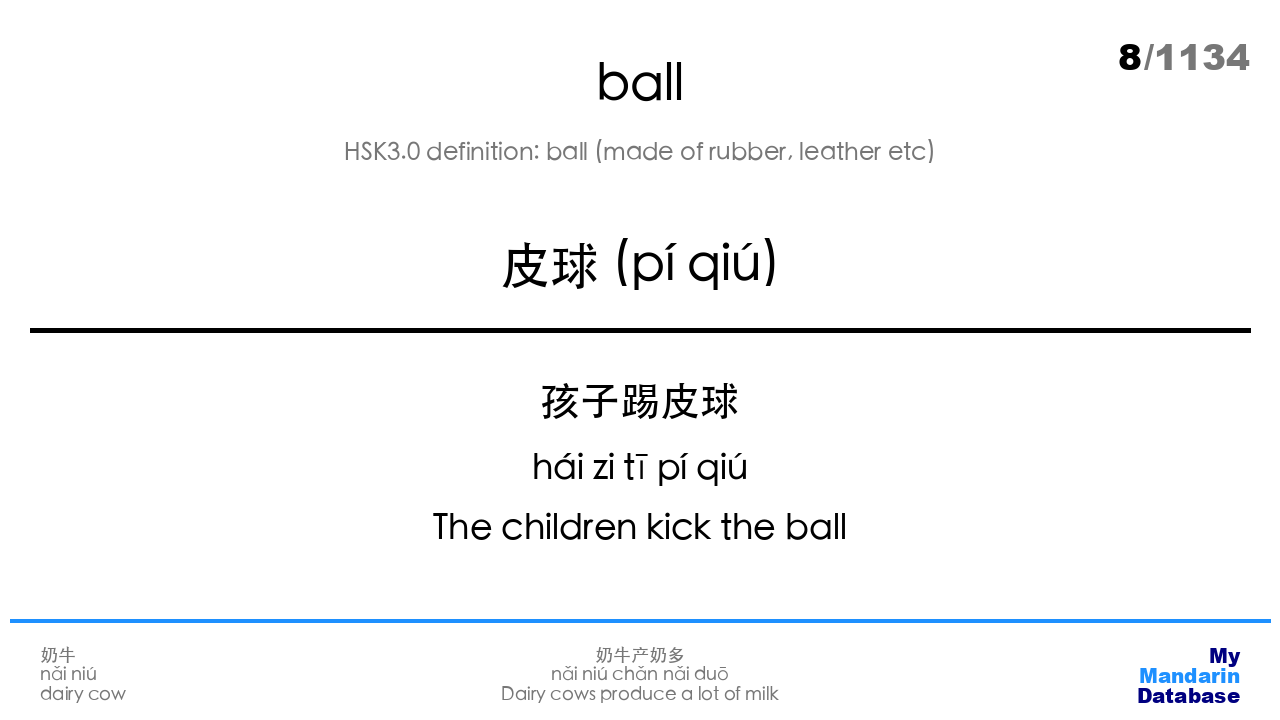

In [13]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


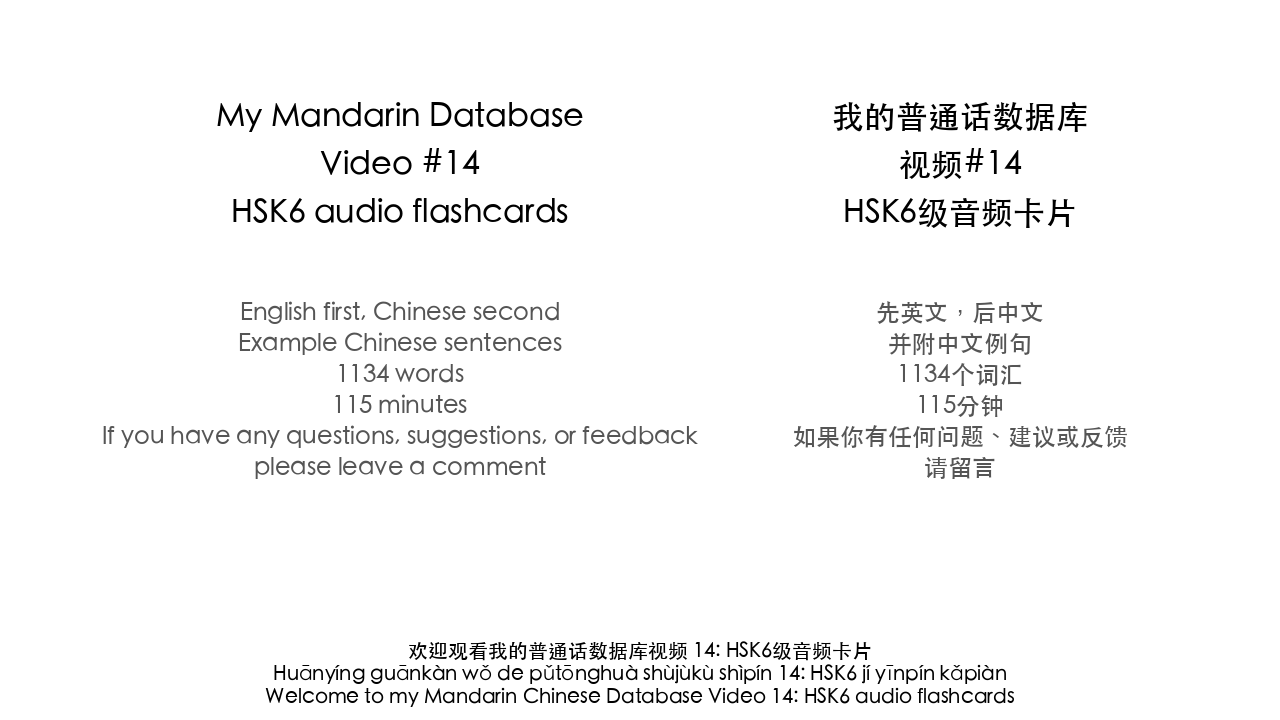

In [14]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced fon


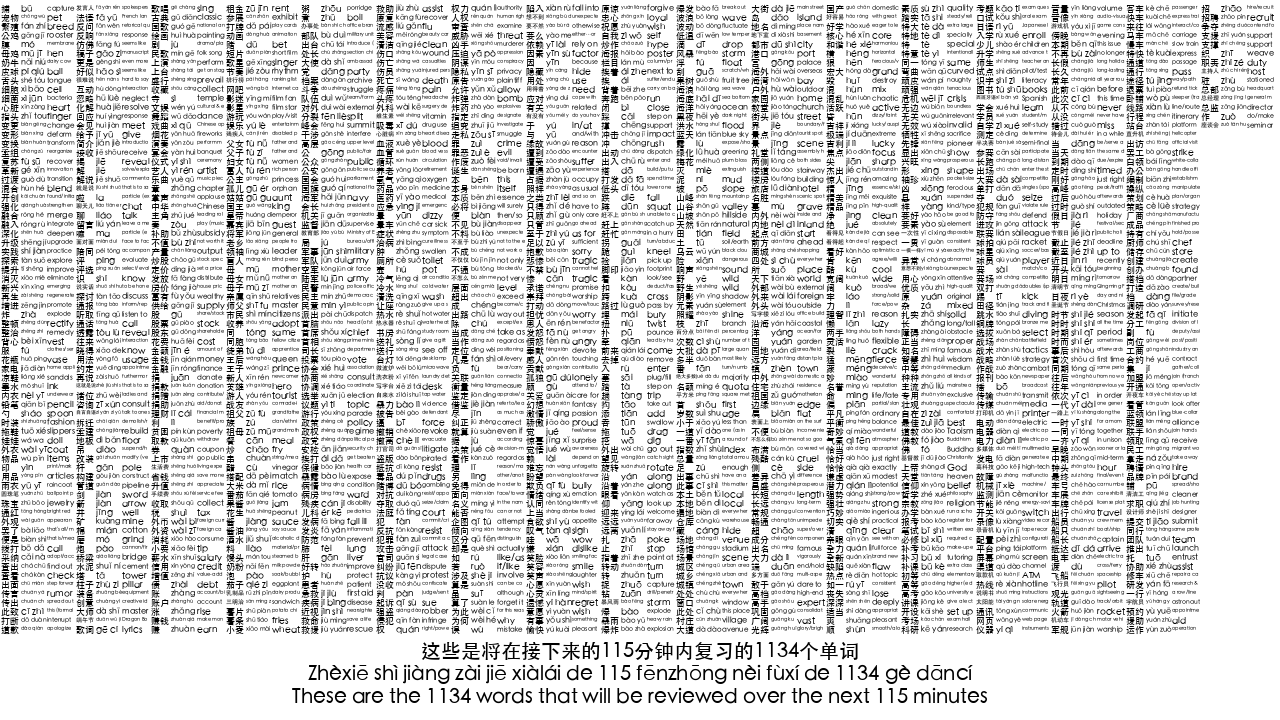

In [15]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced fon


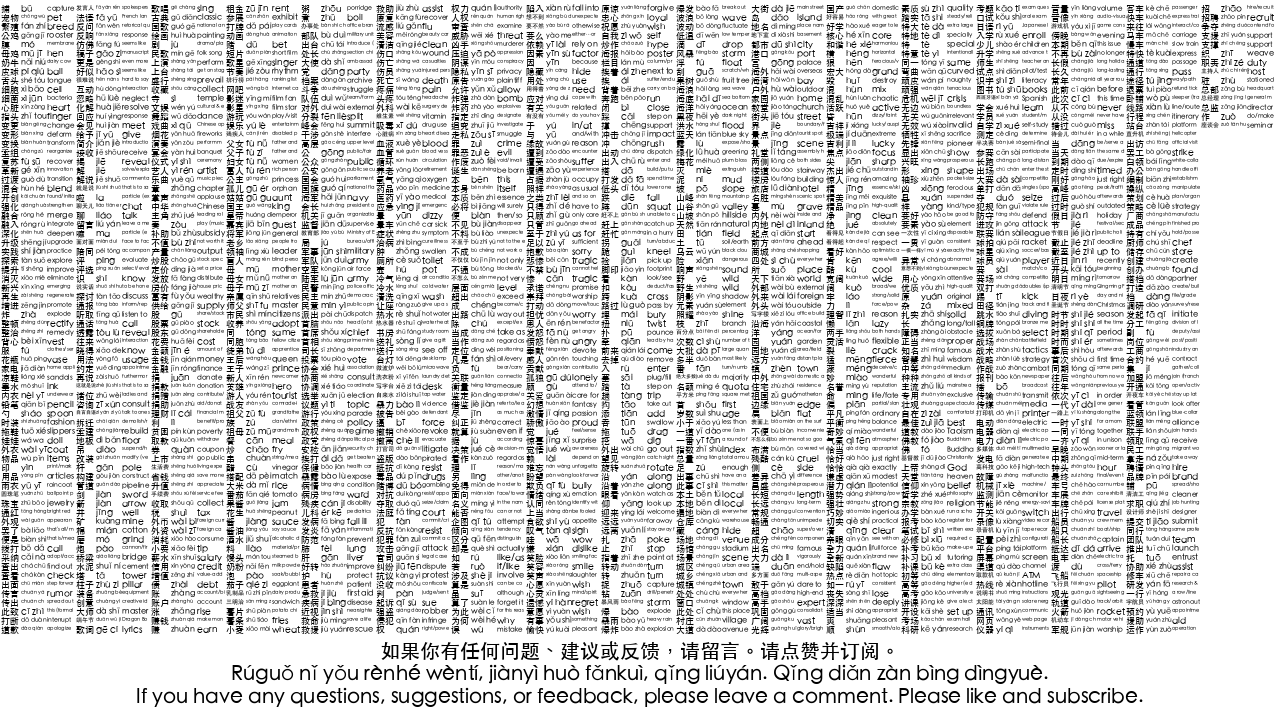

In [16]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


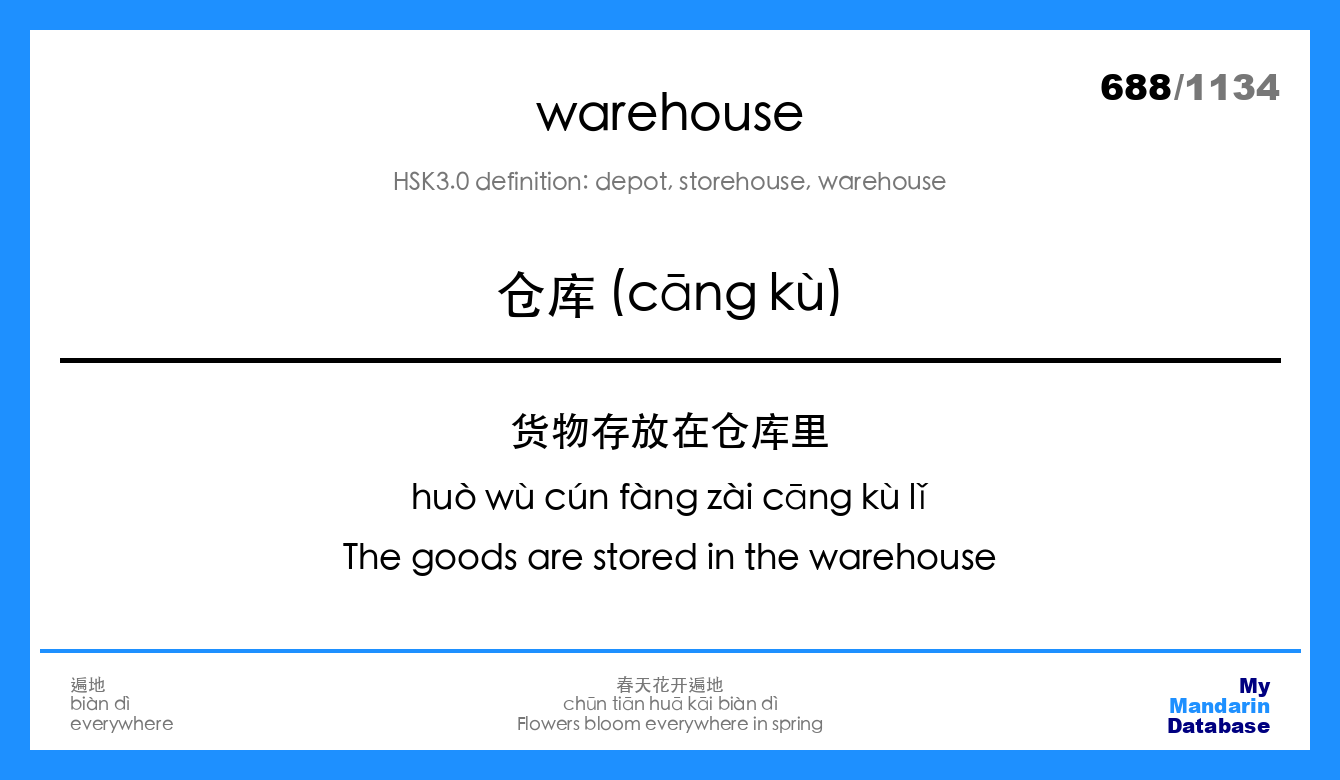

In [17]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()


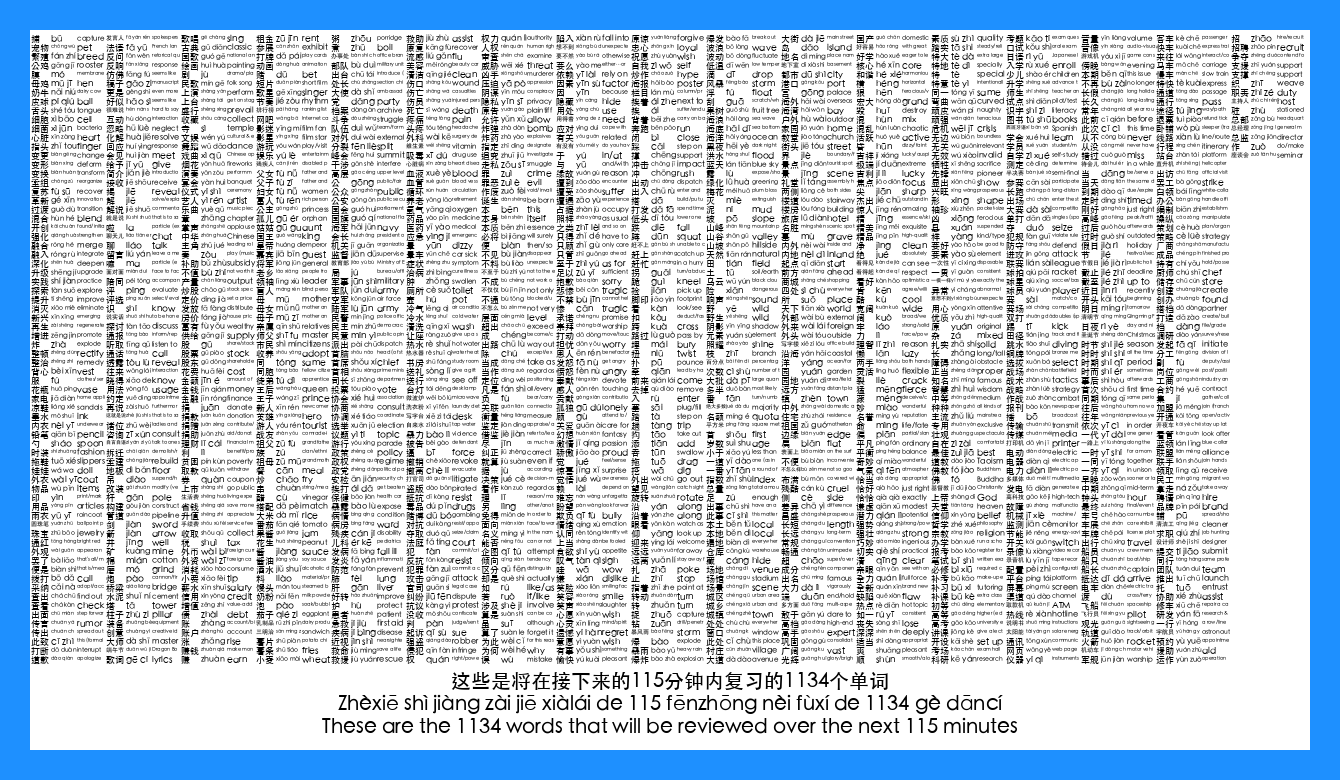

In [18]:
path_to_bottom_image = f"{project_artifacts_folder}/word_list.png"
img = create_icon_from_slide_general_path(icon_configs, video_configs, path_to_bottom_image)
img.save(f'{project_artifacts_folder}/icon2.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon2.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [19]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 3405
audio: 6912.310s, video: 6912.260s; difference: 0.050s
MoviePy - Building video output/videos/1003_ec_csent_hsk6_v1/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/1003_ec_csent_hsk6_v1/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/1003_ec_csent_hsk6_v1/video.mp4
